# Serverless Computing: A Developer's Guide to FaaS and OaaS

This tutorial will guide you through two popular paradigms in serverless computing: Function-as-a-Service (FaaS) and Object-as-a-Service (OaaS). We'll start with FaaS, explore its common patterns and limitations, and then introduce OaaS as an approach designed to address some of these challenges.

**YOU DON'T NEED TO RUN THE CODE. THE PURPOSE OF USING COLAB IS SYNTAX HIGHLIGHTING.**
---



## 1. Understanding Function-as-a-Service (FaaS)

FaaS is a serverless execution model where applications are built as a collection of independent, stateless functions. These functions are triggered by events (e.g., an HTTP request, a new file in storage, a message in a queue), run their logic, and then shut down. You only pay for the execution time.



### A Typical FaaS (e.g., AWS Lambda) API

In many FaaS platforms like AWS Lambda, a function typically accepts two arguments:
* `event`: A JSON-formatted document (Python dictionary) containing data for the function to process.
* `context`: An object providing runtime information about the invocation, function, and execution environment.

The function then returns a value, often a JSON-formatted document as `dict`.



### FaaS Example: A Simple Visitor Counter

Let's imagine we want to count website visitors.

**Attempt 1: Basic FaaS function (Conceptual)**

In [1]:
# A simple in-memory counter (will not work for persistent state in FaaS)
visit_count = 0

def lambda_handler(event, context):
    global visit_count
    visit_count += 1

    # 'user_id' might come from the event payload
    user_id = event.get("user_id", "anonymous")

    print(f"User {user_id} visited. Total visits (this invocation instance): {visit_count}")

    return {
        "statusCode": 200,
        "body": f"Hello user {user_id}! This is visit number {visit_count} (for this instance)."
    }

# Example invocation:
# event_data = {"user_id": "user123"}
# lambda_handler(event_data, None)

**The Problem:** The `visit_count` above is stored in the memory of the function's execution environment. FaaS functions are often stateless, meaning each invocation might run in a fresh environment, or an environment might be reused for a short period but then discarded. Thus, this counter would not be reliable across different users or over time.





### State Management in FaaS

Since functions are stateless, any data that needs to persist beyond a single invocation must be stored externally. Common solutions include databases (like Amazon DynamoDB, RDS), in-memory caches (like Redis, Memcached), or object storage (like Amazon S3).

**FaaS Example: Visitor Counter with External State (Conceptual - S3)**

Let's make our counter persist by using an external storage service (conceptually, like AWS S3 or a simple key-value store).

In [ ]:
# Assume 's3_client' is initialized and configured (e.g., using Boto3 for AWS S3)
# For simplicity, let's mock its behavior.
class MockS3Client:
    def __init__(self):
        self._storage = {} # Simulates S3 bucket

    def get_object(self, bucket, key):
        if key in self._storage:
            return {"Body": str(self._storage[key])} # S3 returns a stream, an int for simplicity
        raise FileNotFoundError # Or appropriate S3 error

    def put_object(self, bucket, key, body):
        self._storage[key] = body
        print(f"S3 Mock: Stored {body} at {key}")

s3_client = MockS3Client() # In a real scenario, this would be an actual S3 client.
COUNTER_BUCKET = "my-visitor-counts"
COUNTER_KEY = "site_visitor_count.txt"

def lambda_handler_persistent(event, context):
    current_count = 0
    try:
        response = s3_client.get_object(Bucket=COUNTER_BUCKET, Key=COUNTER_KEY)
        current_count = int(response['Body']) # Read and parse current count
    except FileNotFoundError: # Or specific S3 "NoSuchKey" error
        print("Counter file not found, initializing to 0.")
        current_count = 0
    except Exception as e:
        print(f"Error reading from S3: {e}")
        # Handle error, maybe return an error response

    current_count += 1

    try:
        s3_client.put_object(Bucket=COUNTER_BUCKET, Key=COUNTER_KEY, Body=str(current_count))
    except Exception as e:
        print(f"Error writing to S3: {e}")
        # Handle error

    user_id = event.get("user_id", "anonymous")

    return {
        "statusCode": 200,
        "body": f"Hello user {user_id}! You are visitor number {current_count}."
    }

# Example invocation:
# event_data = {"user_id": "user456"}
# print(lambda_handler_persistent(event_data, None))
# print(lambda_handler_persistent(event_data, None)) # Call again to see increment



### Function-to-Function Calls and Orchestration

Often, a task requires multiple FaaS functions to work together.
* **Direct Invocation:** One function can directly (synchronously or asynchronously) invoke another. This can create tight coupling and complex dependency graphs.
* **Queues/Streams:** Functions can communicate via message queues (like SQS) or streams (like Kinesis) for more decoupled architectures.
* **Orchestration Services:** Services like AWS Step Functions help manage complex workflows involving multiple functions.

**FaaS Example: Order Processing (Conceptual)**

Imagine an e-commerce order:
1.  `place_order_function`: Receives order, validates it, stores it, then triggers payment.
2.  `process_payment_function`: Processes payment, then triggers inventory update.
3.  `update_inventory_function`: Updates inventory, then triggers shipping.

In [ ]:
# Assume 'lambda_client' for invoking other Lambda functions
class MockLambdaClient:
    def invoke(self, function_name, payload):
        print(f"MockLambda: Invoking {function_name} with payload: {payload}")
        # In reality, this would call another Lambda and get its response.
        # For simplicity, we'll just print and simulate a success.
        if function_name == "process_payment_function":
            return {"status": "payment_successful", "payment_id": "pid_123"}
        elif function_name == "update_inventory_function":
            return {"status": "inventory_updated", "items_deducted": payload.get("items", [])}
        return {"status": "invoked"}

lambda_client = MockLambdaClient()

def place_order_function(event, context):
    order_details = event.get("order")
    print(f"Placing order: {order_details}")
    # ... validate order, store in database (external state) ...

    # Trigger payment function
    payment_payload = {"order_id": order_details["id"], "amount": order_details["total"]}
    payment_response = lambda_client.invoke(
        function_name="process_payment_function",
        payload=payment_payload
    )

    if payment_response.get("status") == "payment_successful":
        print("Payment successful, now updating inventory.")
        # This becomes complex if you need to pass state or manage failures
        # In a real app, you might use Step Functions here or a queue.
        inventory_payload = {"order_id": order_details["id"], "items": order_details["items"]}
        lambda_client.invoke(
            function_name="update_inventory_function",
            payload=inventory_payload
        )

    return {"status": "order_placed", "order_id": order_details["id"]}

def process_payment_function(event, context):
    # ... process payment using event.get("order_id") and event.get("amount") ...
    print(f"Processing payment for order: {event.get('order_id')}")
    # Calls external payment gateway
    return {"status": "payment_successful", "payment_id": f"pid_{event.get('order_id')}"}

def update_inventory_function(event, context):
    # ... update inventory in database (external state) ...
    print(f"Updating inventory for order: {event.get('order_id')}")
    return {"status": "inventory_updated", "items_deducted": event.get("items", [])}

# Example invocation:
# order_data = {"order": {"id": "ord789", "total": 99.99, "items": ["itemA", "itemB"]}}
# place_order_function(order_data, None)

Managing the flow, error handling, and state across these functions can become complex.

---

## 3. Introduction to Object-as-a-Service (OaaS)

OaaS is an architectural paradigm that aims to simplify serverless development by treating **objects** as the fundamental unit of computation and deployment, rather than stateless functions. You can use OaaS by importing and using the `oaas-sdk2-py` library in Python.



### Core Idea

Instead of writing separate functions and managing their state externally, you define classes with methods and state. The OaaS platform handles the persistence and availability of these objects. When you invoke a method on an object, the platform ensures the object is loaded (with its state) and the method is executed.

This model aligns closely with Object-Oriented Programming (OOP) principles, making it intuitive for many developers.



### Key API Concepts of OaaS (with `oaas-sdk2-py`)

- Global `oaas` service: the entry point for decorators, server/agent control, and configuration.
- `OaasObject`: base class providing automatic state management from type-annotated fields.
- Decorators:
  - `@oaas.service(name, package="default")` to register a class as a service
  - `@oaas.method(...)` to expose methods as RPC endpoints (with timeouts/retries/agent options)
  - `@oaas.function(...)` for stateless functions on the class
  - `@oaas.constructor(...)` for custom initialization run by `create()`
  - Optional accessors: `@oaas.getter`, `@oaas.setter` for typed field reads/writes that aren’t exported as RPC
- Typed state: any type-annotated attribute on the class becomes persisted automatically (no manual `get_data`/`set_data`).
- Lifecycle helpers: `MyService.create(obj_id=...)` and `MyService.load(obj_id)` for instance management.
- Configuration: create an `OaasConfig` and call `oaas.configure(config)`; support for `mock_mode`, `async_mode`, partitions, etc.



## 4. OaaS Example: Visitor Counter Revisited

Let's build the visitor counter using OaaS.

In [1]:
from oaas_sdk2_py import oaas, OaasObject, OaasConfig
from pydantic import BaseModel  # optional

# Configure (optional)
config = OaasConfig(async_mode=True, mock_mode=True)
oaas.configure(config)

@oaas.service("VisitorCounter", package="examples")
class Counter(OaasObject):
    count: int = 0  # typed state is persisted automatically

    @oaas.method()
    async def increment(self, user_id: str = "anonymous") -> str:
        self.count += 1
        return f"Hello user {user_id}! You are visitor number {self.count}."

    @oaas.getter()
    async def get_count(self) -> int:
        return self.count

# Create/load and call methods
counter = Counter.create(obj_id=1)
print(await counter.increment("userA"))
print(await counter.increment("userB"))
print("Current count:", await counter.get_count())

Hello user userA! You are visitor number 1.
Hello user userB! You are visitor number 2.
Current count: 2


State is now managed via typed attributes on the class (e.g., `count: int = 0`), so you don’t need manual `get_data()`/`set_data()` in most cases.

### How you interact with your object
This part is illustrative of how you can use your class.
Actual object creation/loading in a live OaaS environment can use `oaas` API directly. In this example, we don't has the running environment, we need to create mocking environment with `oaas.mock()`.


In [2]:
# Local/mock usage: create or load by id and call methods
counter = Counter.create(obj_id=1)
print(await counter.increment("userC"))
print("Final count:", await counter.get_count())

Hello user userC! You are visitor number 1.
Final count: 1




---



## 5. OaaS Example: Object Interaction (Function-to-Function Call Equivalent)

In OaaS, instead of "function-to-function" calls, you typically have "object-to-object" method invocations. Objects can hold references to other objects (or their IDs) and call their methods.

Let's extend our example: a `UserManager` object that, when a user logs in, also increments a global `SessionCounter` object.

In [3]:
from oaas_sdk2_py import oaas, OaasObject

@oaas.service("SessionCounter", package="examples")
class SessionCounter(OaasObject):
    count: int = 0

    @oaas.method()
    async def increment_sessions(self) -> int:
        self.count += 1
        print(f"SessionCounter: Active sessions now {self.count}")
        return self.count

@oaas.service("UserManager", package="examples")
class UserManager(OaasObject):
    session_counter_id: int | None = None

    @oaas.constructor()
    def initialize(self, session_counter_id: int):
        self.session_counter_id = session_counter_id

    @oaas.method()
    async def login_user(self, user_id: str) -> str:
        print(f"UserManager: User {user_id} attempting to log in.")
        if self.session_counter_id is not None:
            counter = SessionCounter.load(self.session_counter_id)
            await counter.increment_sessions()
        return f"User {user_id} logged in successfully."

# Create objects and interact
global_counter = SessionCounter.create(obj_id=100)
user_mgr = UserManager.create(obj_id=200)
user_mgr.initialize(100)
print(await user_mgr.login_user("Alice"))
print(await user_mgr.login_user("Bob"))
print("Final session count:", SessionCounter.load(100).count)

INFO:oaas_sdk:Service SessionCounter successfully registered
INFO:oaas_sdk:Service UserManager successfully registered
ERROR:oaas_sdk:StateDescriptor __get__ error for count: 'Object with metadata ObjectMetadata { object_id: 100, cls_id: examples.SessionCounter, partition_id: 0 } not found'
ERROR:oaas_sdk:StateDescriptor __get__ error for count: 'Object with metadata ObjectMetadata { object_id: 100, cls_id: examples.SessionCounter, partition_id: 0 } not found'
ERROR:oaas_sdk:StateDescriptor __get__ error for count: 'Object with metadata ObjectMetadata { object_id: 100, cls_id: examples.SessionCounter, partition_id: 0 } not found'


UserManager: User Alice attempting to log in.
SessionCounter: Active sessions now 1
User Alice logged in successfully.
UserManager: User Bob attempting to log in.
SessionCounter: Active sessions now 1
User Bob logged in successfully.
Final session count: 0


In OaaS, the `UserManager` object can directly call methods on the `SessionCounter` object. If these objects are managed by the OaaS platform, this interaction can be a seamless remote procedure call (RPC) handled by the SDK, without the developer needing to manage HTTP endpoints, request serialization, or service discovery explicitly for this interaction.


## 7. Practical Example
### **Real-Time Parking Lot Occupancy Counter & Reservation System**



#### **1\. Scenario Description**

Design a system to monitor and manage the real-time occupancy of a parking lot. The lot is equipped with simple, individual parking sensors for each spot that report whether a spot is `occupied` or `vacant`. When a driver reserves a spot, a signal light on the spot must be turned on to indicate its reserved status. The system needs to provide a real-time count of available spots and allow drivers to reserve a spot via a mobile app.



#### **2\. Core Requirements**

1. **Real-Time Status:** Each sensor periodically reports its status (`occupied` or `vacant`) to the system via an MQTT message.  
2. **Spot Reservation:** A driver can request to reserve a single parking spot. The system should assign them a vacant spot and update its status to `reserved`.  
3. **Device Communication:** Upon successful reservation, the system must send an MQTT message to the specific parking spot's device to turn on its signal light.  
4. **Dynamic Management:** The system must be able to add or remove parking spots dynamically as the physical lot configuration changes.  
5. **Availability Query:** A user can query the system at any time to get the total number of available (i.e., `vacant`) spots.  
6. **State Tracking:** The system must keep track of the status of each individual spot (`vacant`, `occupied`, `reserved`).

### **3\. FaaS (Function-as-a-Service) Approach**



#### **Design**

In the FaaS model, the logic is broken down into small, stateless functions. Since functions don't maintain memory between invocations, an external database (or a key-value store) is required to manage the state of the parking lot and its spots. Communication with devices is handled by publishing messages to an MQTT broker.

* **`handle_spot_update`**: Triggered by an MQTT message from a sensor. It updates the status of a specific spot in the database.  
* **`reserve_spot`**: Triggered by an API call from a user's app. It scans the database to find a `vacant` spot, changes its status to `reserved`, publishes an MQTT message to the device to turn on its light, and returns the spot's ID.  
* **`get_available_count`**: Triggered by an API call. It queries the database for all spots and counts how many are `vacant`.  
* **`add_spot` / `remove_spot`**: Administrative functions that update the master list of spots in the database.

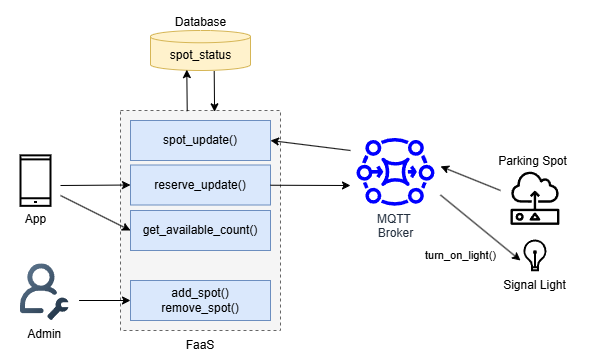


#### **Code Implementation**

In [4]:
from typing import Dict, List, Optional
import json

# --- Mock Infrastructure for FaaS ---
class MockKeyValueStore:
    """
    A mock in-memory key-value store to simulate the external database
    that stateless FaaS functions rely on. It now uses a dictionary as the primary store.
    """
    def __init__(self):
        self._data: Dict[str, str] = {}
        print("MockKeyValueStore: Initialized for FaaS using a dictionary.")

    def get(self, key: str) -> Optional[any]:
        return self._data.get(key)

    def set(self, key: str, value: any):
        self._data[key] = value

    def delete(self, key: str):
        if key in self._data:
            del self._data[key]

    def get_all_spot_ids(self) -> List[str]:
        """Helper method to retrieve all spot IDs from the dictionary keys."""
        return [key for key in self._data.keys()]


class MockMqttClient:
    """
    A mock MQTT client to simulate publishing messages to device topics.
    """
    def publish(self, topic: str, payload: str):
        print(f"MockMqttClient: Publishing to topic '{topic}' with payload: {payload}")

# --- FaaS Function Definitions ---

db = MockKeyValueStore()
mqtt_client = MockMqttClient()

def faas_add_spot(event: dict, context: object):
    """FaaS Function: Adds a new parking spot to the system."""
    spot_id = event['spot_id']
    print(f"FaaS.add_spot: Adding spot '{spot_id}'.")
    db.set(f"spot:{spot_id}", "vacant")
    return {"status": "success", "spot_id": spot_id}

def faas_remove_spot(event: dict, context: object):
    """FaaS Function: Removes a parking spot from the system."""
    spot_id = event['spot_id']
    print(f"FaaS.remove_spot: Removing spot '{spot_id}'.")
    db.delete(f"spot:{spot_id}")
    return {"status": "success", "spot_id": spot_id}


def faas_handle_spot_update(event: dict, context: object):
    """
    FaaS Function: Triggered by a sensor update (e.g., via MQTT).
    Updates the status of a single spot.
    """
    spot_id = event['spot_id']
    new_status = event['new_status']
    print(f"FaaS.handle_spot_update: Sensor reports spot '{spot_id}' is now '{new_status}'.")
    db.set(f"spot:{spot_id}", new_status)
    return {"status": "success"}


def faas_reserve_spot(event: dict, context: object) -> Optional[str]:
    """
    FaaS Function: Triggered by a user request. Finds a vacant spot,
    reserves it, publishes an MQTT command, and returns the spot ID.
    """
    user_id = event['user_id']
    print(f"FaaS.reserve_spot: User '{user_id}' requests a reservation.")
    all_spots = db.get_all_spot_ids()
    if not all_spots:
        return {"spot_id": None}

    for spot_key in all_spots:
        spot_status = db.get(spot_key)
        if spot_status == "vacant":
            db.set(spot_key, "reserved")
            spot_id = spot_key.split(':')[1]
            print(f"FaaS.reserve_spot: Reserved '{spot_id}' for user '{user_id}'.")

            # Publish MQTT message to turn on the signal light for the device
            topic = f"parking/lot-A/spot-{spot_id}/command"
            payload = json.dumps({"command": "turn_on_light"})
            mqtt_client.publish(topic, payload)

            return {"spot_id": spot_id}
    print("FaaS.reserve_spot: No vacant spots were found.")
    return {"spot_id": None}

def faas_get_available_count(event: dict, context: object) -> int:
    """
    FaaS Function: Triggered by a user request.
    Counts and returns the number of vacant spots.
    """
    count = 0
    all_spot_keys = db.get_all_spot_ids()
    if all_spot_keys:
        for spot_key in all_spot_keys:
            if db.get(spot_key) == "vacant":
                count += 1
    print(f"FaaS.get_available_count: Found {count} available spots.")
    return {"available_spots": count}

MockKeyValueStore: Initialized for FaaS using a dictionary.


In [5]:

def demonstrate_faas_approach():
    """Runs a sequence of operations using the FaaS implementation."""
    print("--- DEMONSTRATING FaaS APPROACH ---")
    faas_add_spot({"spot_id": "A1"}, None)
    faas_add_spot({"spot_id": "A2"}, None)
    faas_add_spot({"spot_id": "A3"}, None)

    faas_get_available_count({}, None)

    response = faas_reserve_spot({"user_id": "user-123"}, None)
    reserved_spot_id = response.get('spot_id')
    print(f"FaaS Main: Reservation successful for spot: {reserved_spot_id}")

    if reserved_spot_id:
        faas_handle_spot_update({"spot_id": f"spot:{reserved_spot_id}", "new_status": "occupied"}, None)

    faas_get_available_count({}, None)

demonstrate_faas_approach()

--- DEMONSTRATING FaaS APPROACH ---
FaaS.add_spot: Adding spot 'A1'.
FaaS.add_spot: Adding spot 'A2'.
FaaS.add_spot: Adding spot 'A3'.
FaaS.get_available_count: Found 3 available spots.
FaaS.reserve_spot: User 'user-123' requests a reservation.
FaaS.reserve_spot: Reserved 'A1' for user 'user-123'.
MockMqttClient: Publishing to topic 'parking/lot-A/spot-A1/command' with payload: {"command": "turn_on_light"}
FaaS Main: Reservation successful for spot: A1
FaaS.handle_spot_update: Sensor reports spot 'spot:A1' is now 'occupied'.
FaaS.get_available_count: Found 2 available spots.


### **4\. OaaS (Object-as-a-Service) Approach**



#### **Design**

In the OaaS model, we create stateful objects that directly represent the real-world entities. The state is encapsulated within the objects themselves, and the logic is implemented as methods on these objects. This eliminates the need for a separate, external database for managing application state.

* **`ParkingSpot` Class**: A stateful object representing a single spot.  
  * **State**: `status` (e.g., 'vacant', 'occupied', 'reserved'), `spot_id`.  
  * **Methods**: `update_status()`, `get_status()`, `reserve()`, `turn_light()`.  
* **`ParkingLot` Class**: A stateful object that manages the entire lot.  
  * **State**: A list of `ParkingSpot` object instances.  
  * **Methods**: `add_spot()`, `remove_spot()`, `reserve_spot()`, `get_available_count()`.

The `ParkingLot` object directly calls methods on the `ParkingSpot` objects it contains, including the method to turn on the light, creating a clear and intuitive object-oriented model.

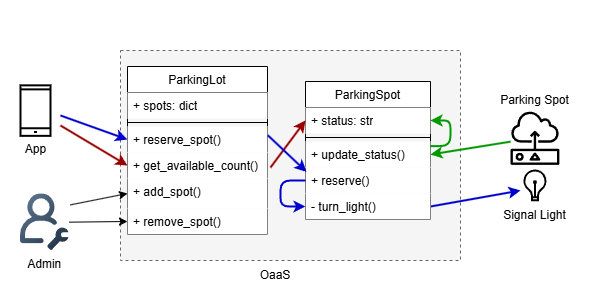


#### **Code Implementation**

In [6]:
from typing import Dict, Optional
from oaas_sdk2_py import oaas, OaasObject

@oaas.service("ParkingSpot", package="parking")
class ParkingSpot(OaasObject):
    spot_id: str = ""
    status: str = "vacant"   # vacant | occupied | reserved
    light_on: bool = False

    @oaas.constructor()
    def initialize(self, spot_id: str):
        self.spot_id = spot_id
        self.status = "vacant"
        self.light_on = False

    @oaas.getter("status")
    async def get_status(self) -> str:
        return self.status

    @oaas.method()
    async def set_status(self, new_status: str) -> str:
        print(f"OaaS.ParkingSpot '{self.spot_id}': Status changing to '{new_status}'.")
        self.status = new_status
        return self.status

    @oaas.method()
    async def reserve(self) -> bool:
        if self.status == "vacant":
            self.status = "reserved"
            print(f"OaaS.ParkingSpot '{self.spot_id}': Has been successfully reserved.")
            return True
        return False

    @oaas.method(serve_with_agent=True)
    async def set_light(self, on: bool) -> bool:
        # In production, talk to device via MQTT/Zenoh here
        self.light_on = on
        if on:
            print(f"OaaS.ParkingSpot '{self.spot_id}': Command sent to TURN ON LIGHT.")
        else:
            print(f"OaaS.ParkingSpot '{self.spot_id}': Command sent to TURN OFF LIGHT.")
        return self.light_on

@oaas.service("ParkingLot", package="parking")
class ParkingLot(OaasObject):
    lot_id: str = ""
    spots: Dict[str, int] = {}   # map spot_id -> object_id

    @oaas.constructor()
    def initialize(self, lot_id: str):
        self.lot_id = lot_id
        self.spots = {}

    @oaas.method()
    async def add_spot(self, spot_id: str, spot_obj_id: int) -> bool:
        print(f"OaaS.ParkingLot '{self.lot_id}': Adding spot '{spot_id}'.")
        self.spots[spot_id] = spot_obj_id
        return True

    @oaas.method()
    async def remove_spot(self, spot_id: str) -> bool:
        print(f"OaaS.ParkingLot '{self.lot_id}': Removing spot '{spot_id}'.")
        self.spots.pop(spot_id, None)
        return True

    @oaas.method()
    async def reserve_any(self, user_id: str) -> Optional[str]:
        print(f"OaaS.ParkingLot '{self.lot_id}': User '{user_id}' requests a reservation.")
        for spot_id, spot_obj_id in self.spots.items():
            spot_obj = ParkingSpot.load(spot_obj_id)
            if await spot_obj.get_status() == "vacant":
                if await spot_obj.reserve():
                    await spot_obj.set_light(True)
                    print(f"OaaS.ParkingLot '{self.lot_id}': Reserved '{spot_id}'.")
                    return spot_id
        print(f"OaaS.ParkingLot '{self.lot_id}': No vacant spots were found.")
        return None

# Illustrative flow (local/mock)
lot = ParkingLot.create(obj_id=1)
lot.initialize("Lot-A")
for i in range(1, 4):
    spot = ParkingSpot.create(obj_id=100 + i)
    spot.initialize(f"S{i}")
    await lot.add_spot(f"S{i}", 100 + i)
print("Reserved:", await lot.reserve_any("user-1"))

INFO:oaas_sdk:Service ParkingSpot successfully registered
INFO:oaas_sdk:Service ParkingLot successfully registered


OaaS.ParkingLot 'Lot-A': Adding spot 'S1'.
OaaS.ParkingLot 'Lot-A': Adding spot 'S2'.
OaaS.ParkingLot 'Lot-A': Adding spot 'S3'.
OaaS.ParkingLot 'Lot-A': User 'user-1' requests a reservation.
OaaS.ParkingSpot 'S1': Has been successfully reserved.
OaaS.ParkingSpot 'S1': Command sent to TURN OFF LIGHT.
OaaS.ParkingLot 'Lot-A': Reserved 'S1'.
Reserved: S1



<!-- ## 8. When to Consider OaaS

OaaS can be particularly beneficial when:
* Your application has many interacting components that need to maintain state.
* You prefer an object-oriented approach to designing your serverless application.
* You want to reduce the boilerplate for managing external state and inter-service communication for stateful entities.

This tutorial has provided a conceptual overview. The `oaas-sdk2-py` offers features like a mocking framework for testing and asynchronous support to build robust applications. For more detailed examples of how to use the SDK, including its mocking framework for tests, you can refer to the `README.md` and the examples provided with the SDK. -->
<!-- The SDK's core components are written in Rust for performance. -->